In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import matplotlib.cm as cm


data = pd.read_csv(r'C:/Users/js103/Desktop/SHAP 공부/data/heart.csv')

data = data.rename(
    columns = {'cp':'chest_pain_type', 
               'trestbps':'resting_blood_pressure', 
               'chol': 'cholesterol',
               'fbs': 'fasting_blood_sugar',
               'restecg' : 'resting_electrocardiogram', 
               'thalach': 'max_heart_rate_achieved', 
               'exang': 'exercise_induced_angina',
               'oldpeak': 'st_depression', 
               'slope': 'st_slope', 
               'ca':'num_major_vessels', 
               'thal': 'thalassemia'}, 
    errors="raise")

X = data.drop('target', axis=1)
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Test accuracy:", model.score(X_test, y_test))
print(data.dtypes)
y_pred = model.predict(X_test)

import shap

# Jupyter/Colab에서 인터랙티브 force plot 보려면
shap.initjs()

# TreeExplainer 생성 (RandomForest 같은 tree 모델에 최적)
explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(X_test)

# 출력 형태 확인 (디버그용)
print(type(shap_values))
# 예: list 이면 shap_values[1].shape -> (n_samples, n_features)
if isinstance(shap_values, list):
    print("shap_values for class 0 shape:", shap_values[0].shape)
    print("shap_values for class 1 shape:", shap_values[1].shape)
else:
    # 최신 shap 버전: explainer(X)로 Explanation 객체를 반환할 수 있음.
    print("explainer returned Explanation object with shape info:", shap_values.shape)

# 3차원 배열에서 Class 1 (인덱스 1)의 SHAP 값만 선택
# shap_values[:, :, 1]의 모양은 (61, 13)이 됩니다.
shap_values_class1 = shap_values[:, :, 1]

X_test_df = pd.DataFrame(X_test, columns=X_test.columns)
shap_df = pd.DataFrame(shap_values_class1, columns=X_test.columns)
feature_names = X_test.columns.tolist()

Train shape: (242, 13) Test shape: (61, 13)
Test accuracy: 0.8360655737704918
age                            int64
sex                            int64
chest_pain_type                int64
resting_blood_pressure         int64
cholesterol                    int64
fasting_blood_sugar            int64
resting_electrocardiogram      int64
max_heart_rate_achieved        int64
exercise_induced_angina        int64
st_depression                float64
st_slope                       int64
num_major_vessels              int64
thalassemia                    int64
target                         int64
dtype: object


c:\Users\js103\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<class 'numpy.ndarray'>
explainer returned Explanation object with shape info: (61, 13, 2)


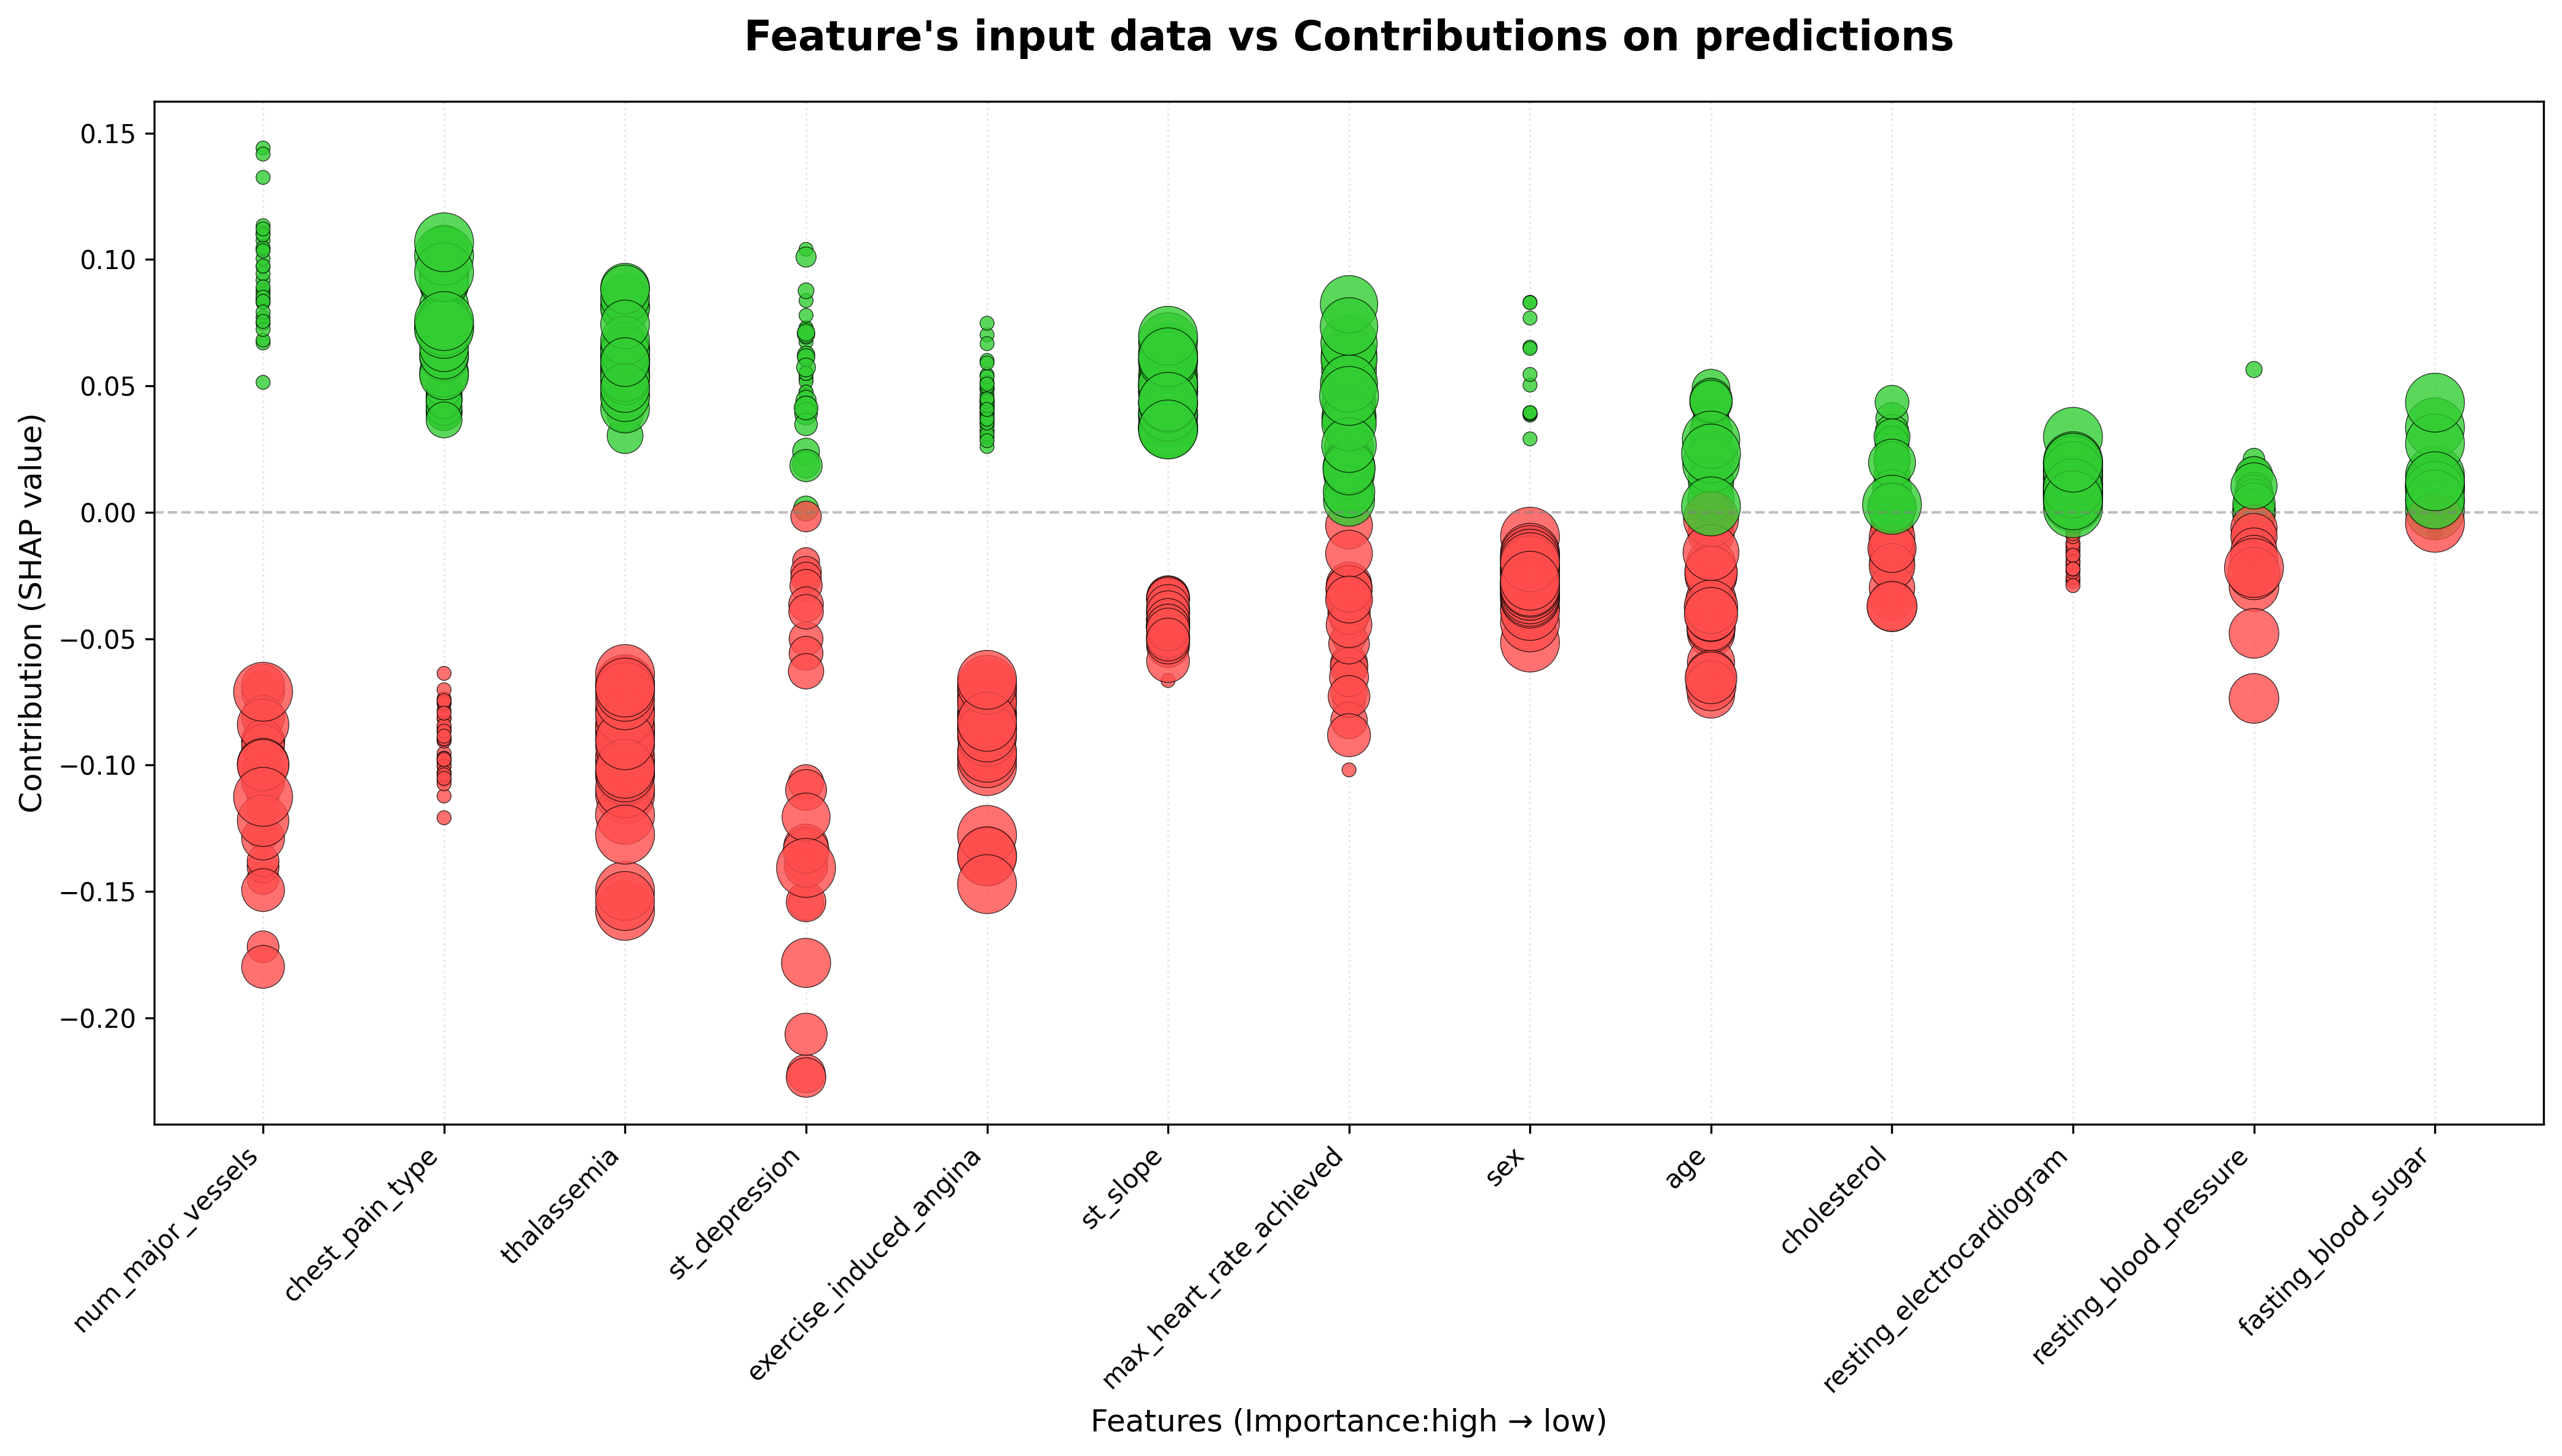

In [2]:
# 1. 특징 중요도 계산
mean_abs_shap = np.abs(shap_values_class1).mean(axis=0)
sorted_idx = np.argsort(mean_abs_shap)[::-1]
sorted_features = X_test.columns[sorted_idx]

# 2. 특징값 정규화
X_norm = X_test.copy()
for col in X_norm.columns:
    min_val = X_test[col].min()
    max_val = X_test[col].max()
    if max_val - min_val == 0:
        X_norm[col] = 0.5
    else:
        X_norm[col] = (X_test[col] - min_val) / (max_val - min_val)

# 3. 플롯 설정
plt.figure(figsize=(14, 8), dpi=300)
ax = plt.gca()

# 4. 각 feature별 산점도
for i, feature in enumerate(sorted_features):
    shap_vals = shap_values_class1[:, X_test.columns.get_loc(feature)]
    sizes = 30 + X_norm[feature] * 500  # 점 크기: 특징값에 비례
    colors = ['#32cd32' if val >= 0 else '#ff4d4d' for val in shap_vals]

    # 특징값 크기 기준으로 오름차순 정렬 (작은 점 뒤, 큰 점 앞으로)
    sort_idx = np.argsort(X_norm[feature])
    shap_sorted = shap_vals[sort_idx]
    sizes_sorted = sizes.iloc[sort_idx]         # ← 수정
    colors_sorted = [colors[j] for j in sort_idx]

    ax.scatter(
        np.full_like(shap_sorted, i),
        shap_sorted,
        s=sizes_sorted,
        c=colors_sorted,
        #c='gray',
        edgecolor='black',
        linewidth=0.3,
        alpha=0.8,
        zorder=2
    )

# 5. 축 및 레이블
plt.title("Feature's input data vs Contributions on predictions", fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Features (Importance:high → low)", fontsize=12)
plt.ylabel("Contribution (SHAP value)", fontsize=12)

plt.xticks(ticks=range(len(sorted_features)), labels=sorted_features, rotation=45, ha='right', fontsize=10)
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5, linewidth=1)

plt.grid(axis='x', linestyle=':', alpha=0.3)
plt.tight_layout()
plt.show()


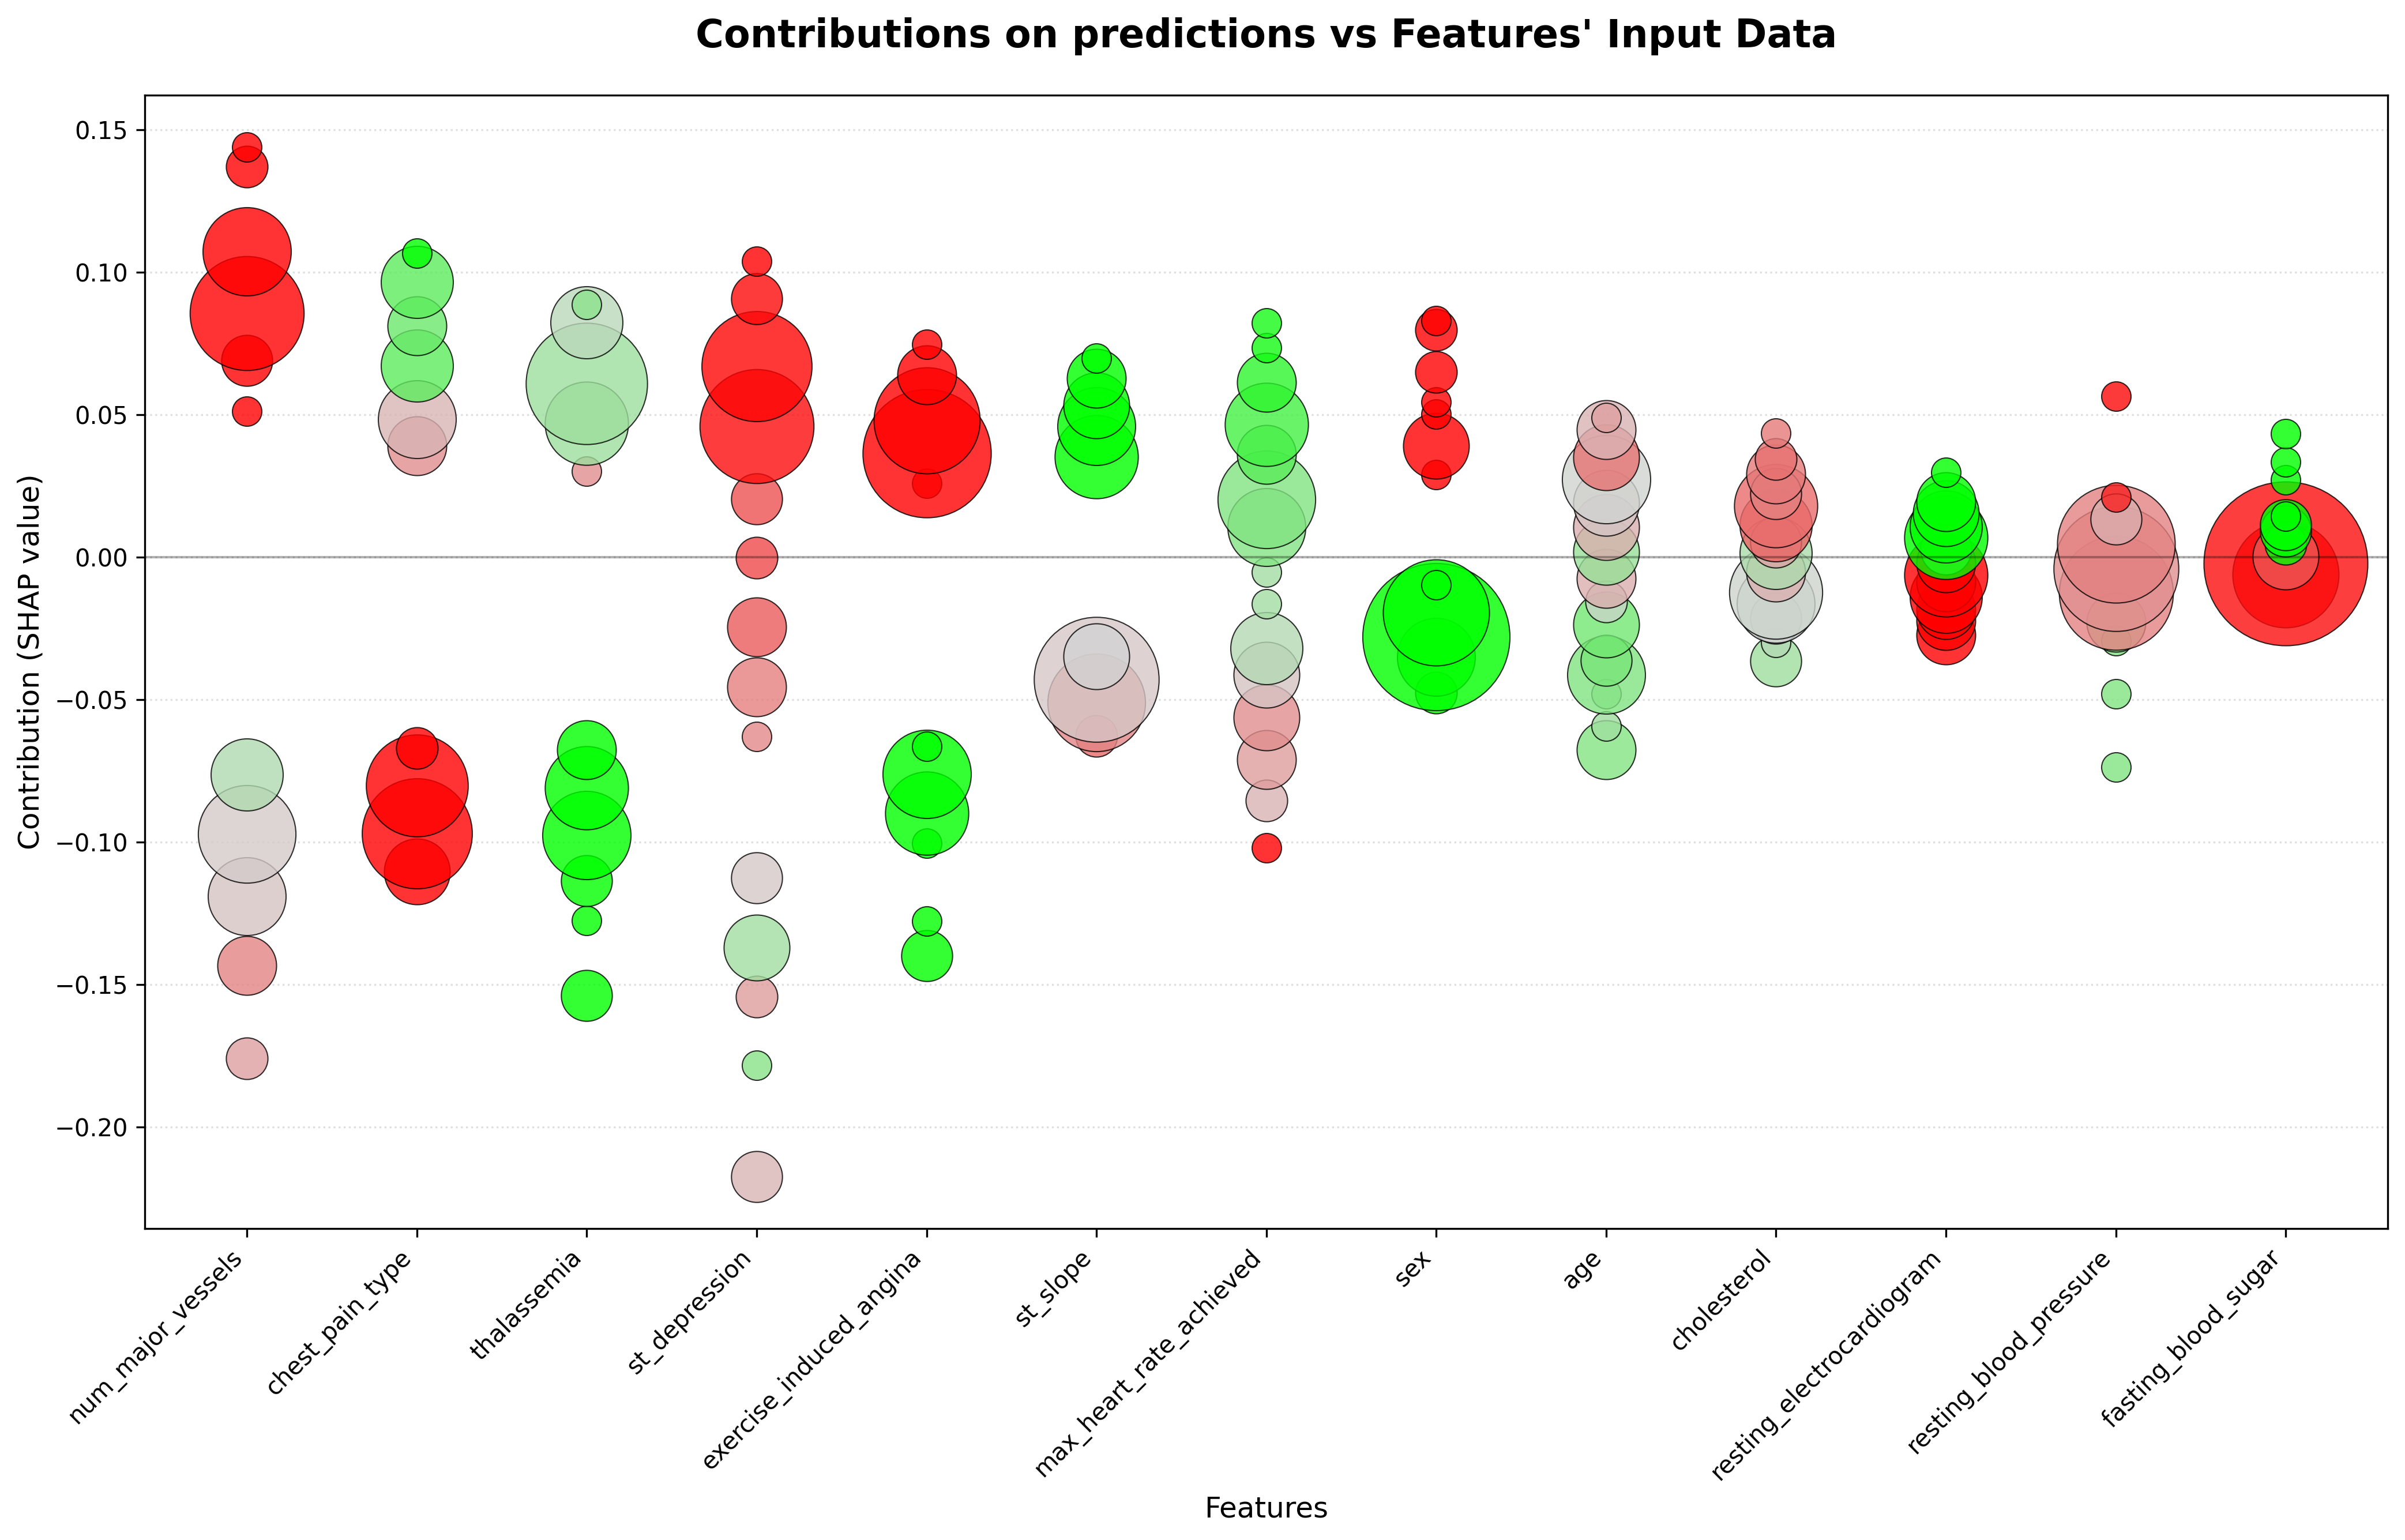

In [3]:

from matplotlib.colors import LinearSegmentedColormap

colors = ["#ff0000", "#d3d3d3", "#00ff00"]
custom_cmap = LinearSegmentedColormap.from_list("custom_shap", colors)

mean_abs_shap = np.abs(shap_values_class1).mean(axis=0)
sorted_idx = np.argsort(mean_abs_shap)[::-1]
sorted_features = X_test.columns[sorted_idx]

plt.figure(figsize=(14, 9), dpi=300)
ax = plt.gca()


num_bins = 15 # 구간(Bin) 개수 설정

for i, feature in enumerate(sorted_features):
    feat_idx = X_test.columns.get_loc(feature)
    shap_vals = shap_values_class1[:, feat_idx]
    norm_vals = X_norm[feature].values 
    
    bins = np.linspace(shap_vals.min(), shap_vals.max(), num_bins)
    bin_indices = np.digitize(shap_vals, bins)
    
    for b in range(1, len(bins) + 1):
        mask = (bin_indices == b)
        if not np.any(mask):
            continue
        
        density = np.sum(mask)
        avg_feature_val = np.mean(norm_vals[mask])
        avg_shap_val = np.mean(shap_vals[mask])
        
        ax.scatter(
            i, 
            avg_shap_val, 
            s=density * 150,           # 밀도에 따른 크기 (가독성을 위해 계수 조정 가능)
            c=[custom_cmap(avg_feature_val)], 
            edgecolor='black',
            linewidth=0.5,
            alpha=0.8,
            zorder=2
        )

plt.title("Contributions on predictions vs Features' Input Data", 
          fontsize=16, fontweight='bold', pad=20)
plt.ylabel("Contribution (SHAP value)", fontsize=12)
plt.xlabel("Features", fontsize=12)

plt.xticks(ticks=range(len(sorted_features)), labels=sorted_features, rotation=45, ha='right')

plt.axhline(y=0, color='black', linestyle='-', alpha=0.3, linewidth=1)
plt.grid(axis='y', linestyle=':', alpha=0.4)


#sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=plt.Normalize(0, 1))
#cb = plt.colorbar(sm, ax=ax, aspect=30, pad=0.02)
#cb.set_label('Feature Value (Red: Low, Gray: Mid, Green: High)', fontsize=10)

plt.tight_layout()
plt.show()

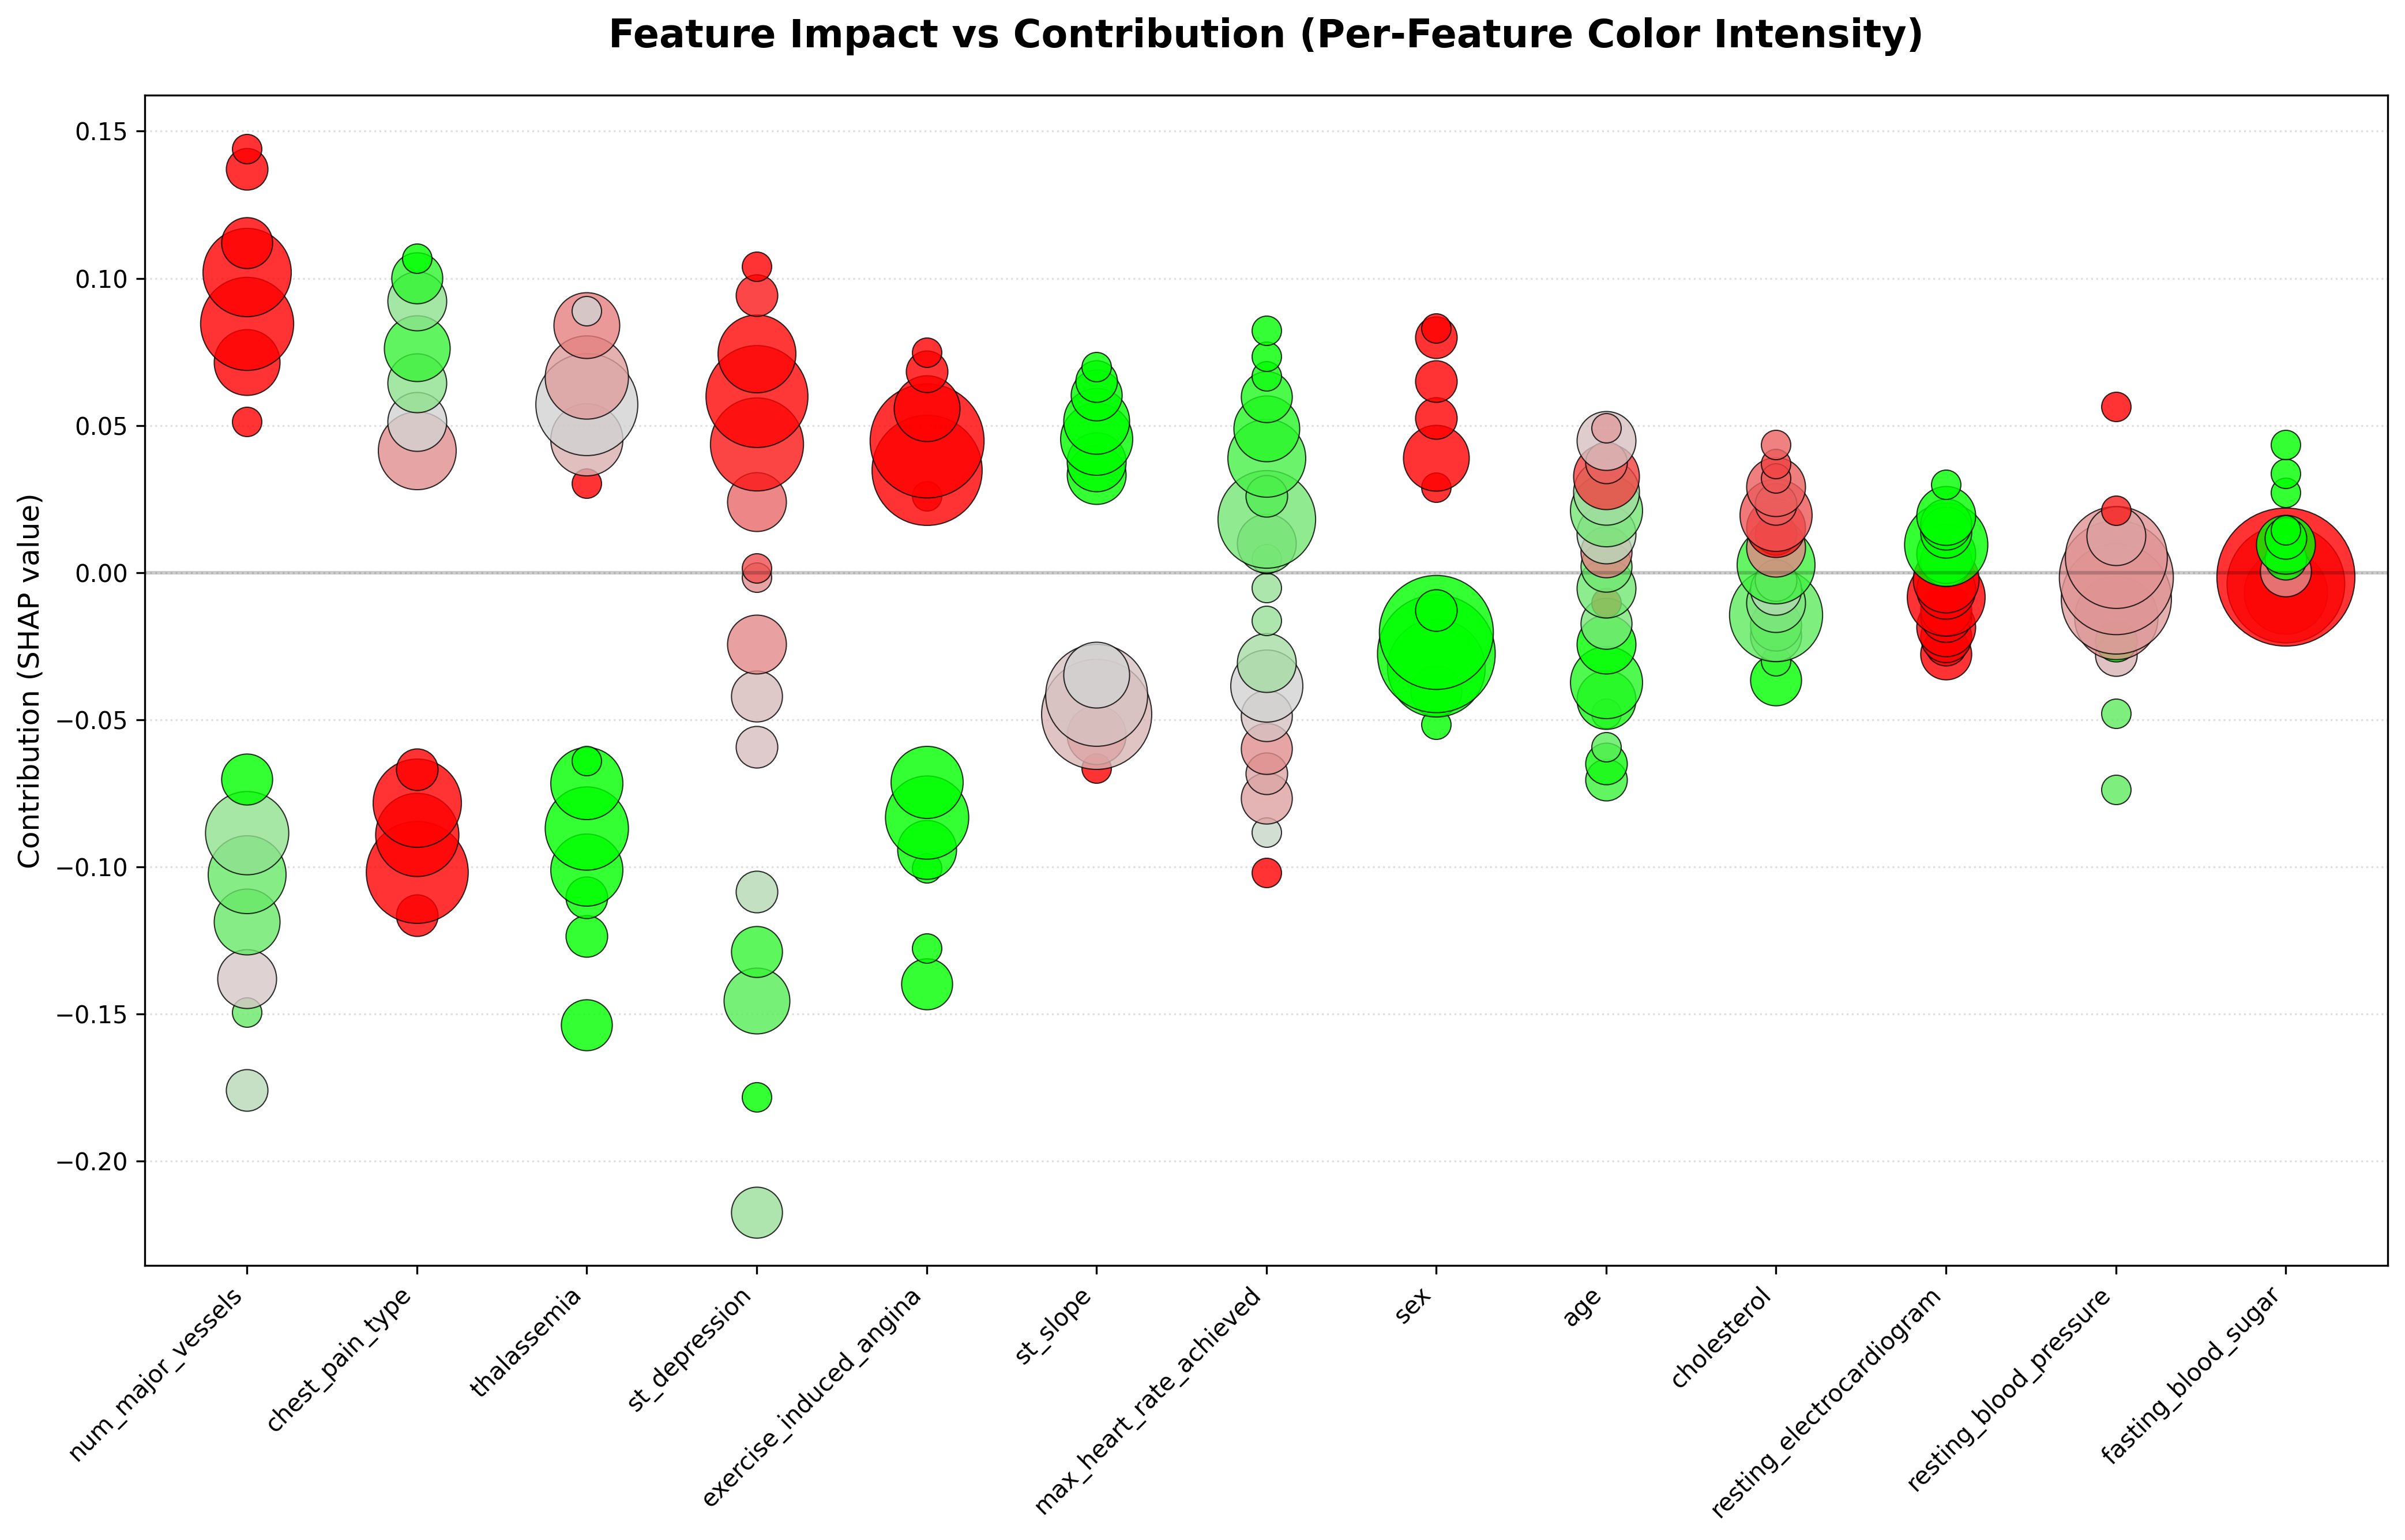

In [4]:

from matplotlib.colors import LinearSegmentedColormap


colors = ["#ff0000", "#d3d3d3", "#00ff00"] # 원색에 가까운 진한 색상
custom_cmap = LinearSegmentedColormap.from_list("custom_shap", colors)


mean_abs_shap = np.abs(shap_values_class1).mean(axis=0)
sorted_idx = np.argsort(mean_abs_shap)[::-1]
sorted_features = X_test.columns[sorted_idx]


plt.figure(figsize=(14, 9), dpi=300)
ax = plt.gca()

num_bins = 20 


for i, feature in enumerate(sorted_features):
    feat_idx = X_test.columns.get_loc(feature)
    shap_vals = shap_values_class1[:, feat_idx]
    norm_vals = X_norm[feature].values 
    
    
    bins = np.linspace(shap_vals.min(), shap_vals.max(), num_bins)
    bin_indices = np.digitize(shap_vals, bins)
    
    feature_bin_results = []
    
    
    for b in range(1, len(bins) + 1):
        mask = (bin_indices == b)
        if not np.any(mask):
            continue
        
        density = np.sum(mask)
        avg_feature_val = np.mean(norm_vals[mask]) # 여기서 희석이 일어남
        avg_shap_val = np.mean(shap_vals[mask])
        
        feature_bin_results.append([density, avg_feature_val, avg_shap_val])
    
    if not feature_bin_results:
        continue
        
    feature_bin_results = np.array(feature_bin_results)
    
   
    current_avg_feats = feature_bin_results[:, 1]
    f_min = current_avg_feats.min()
    f_max = current_avg_feats.max()
    
    for res in feature_bin_results:
        d, avg_f, avg_s = res
        

        if f_max != f_min:
            color_idx = (avg_f - f_min) / (f_max - f_min)
        else:
            color_idx = 0.5 # 모든 평균값이 같다면 회색
            
        ax.scatter(
            i, 
            avg_s, 
            s=d * 150, 
            c=[custom_cmap(color_idx)], # 재조정된 인덱스로 색상 지정
            edgecolor='black',
            linewidth=0.5,
            alpha=0.8,
            zorder=2
        )


plt.title("Feature Impact vs Contribution (Per-Feature Color Intensity)", fontsize=16, fontweight='bold', pad=20)
plt.ylabel("Contribution (SHAP value)", fontsize=12)
plt.xticks(ticks=range(len(sorted_features)), labels=sorted_features, rotation=45, ha='right')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.2)
plt.grid(axis='y', linestyle=':', alpha=0.4)

plt.tight_layout()
plt.show()

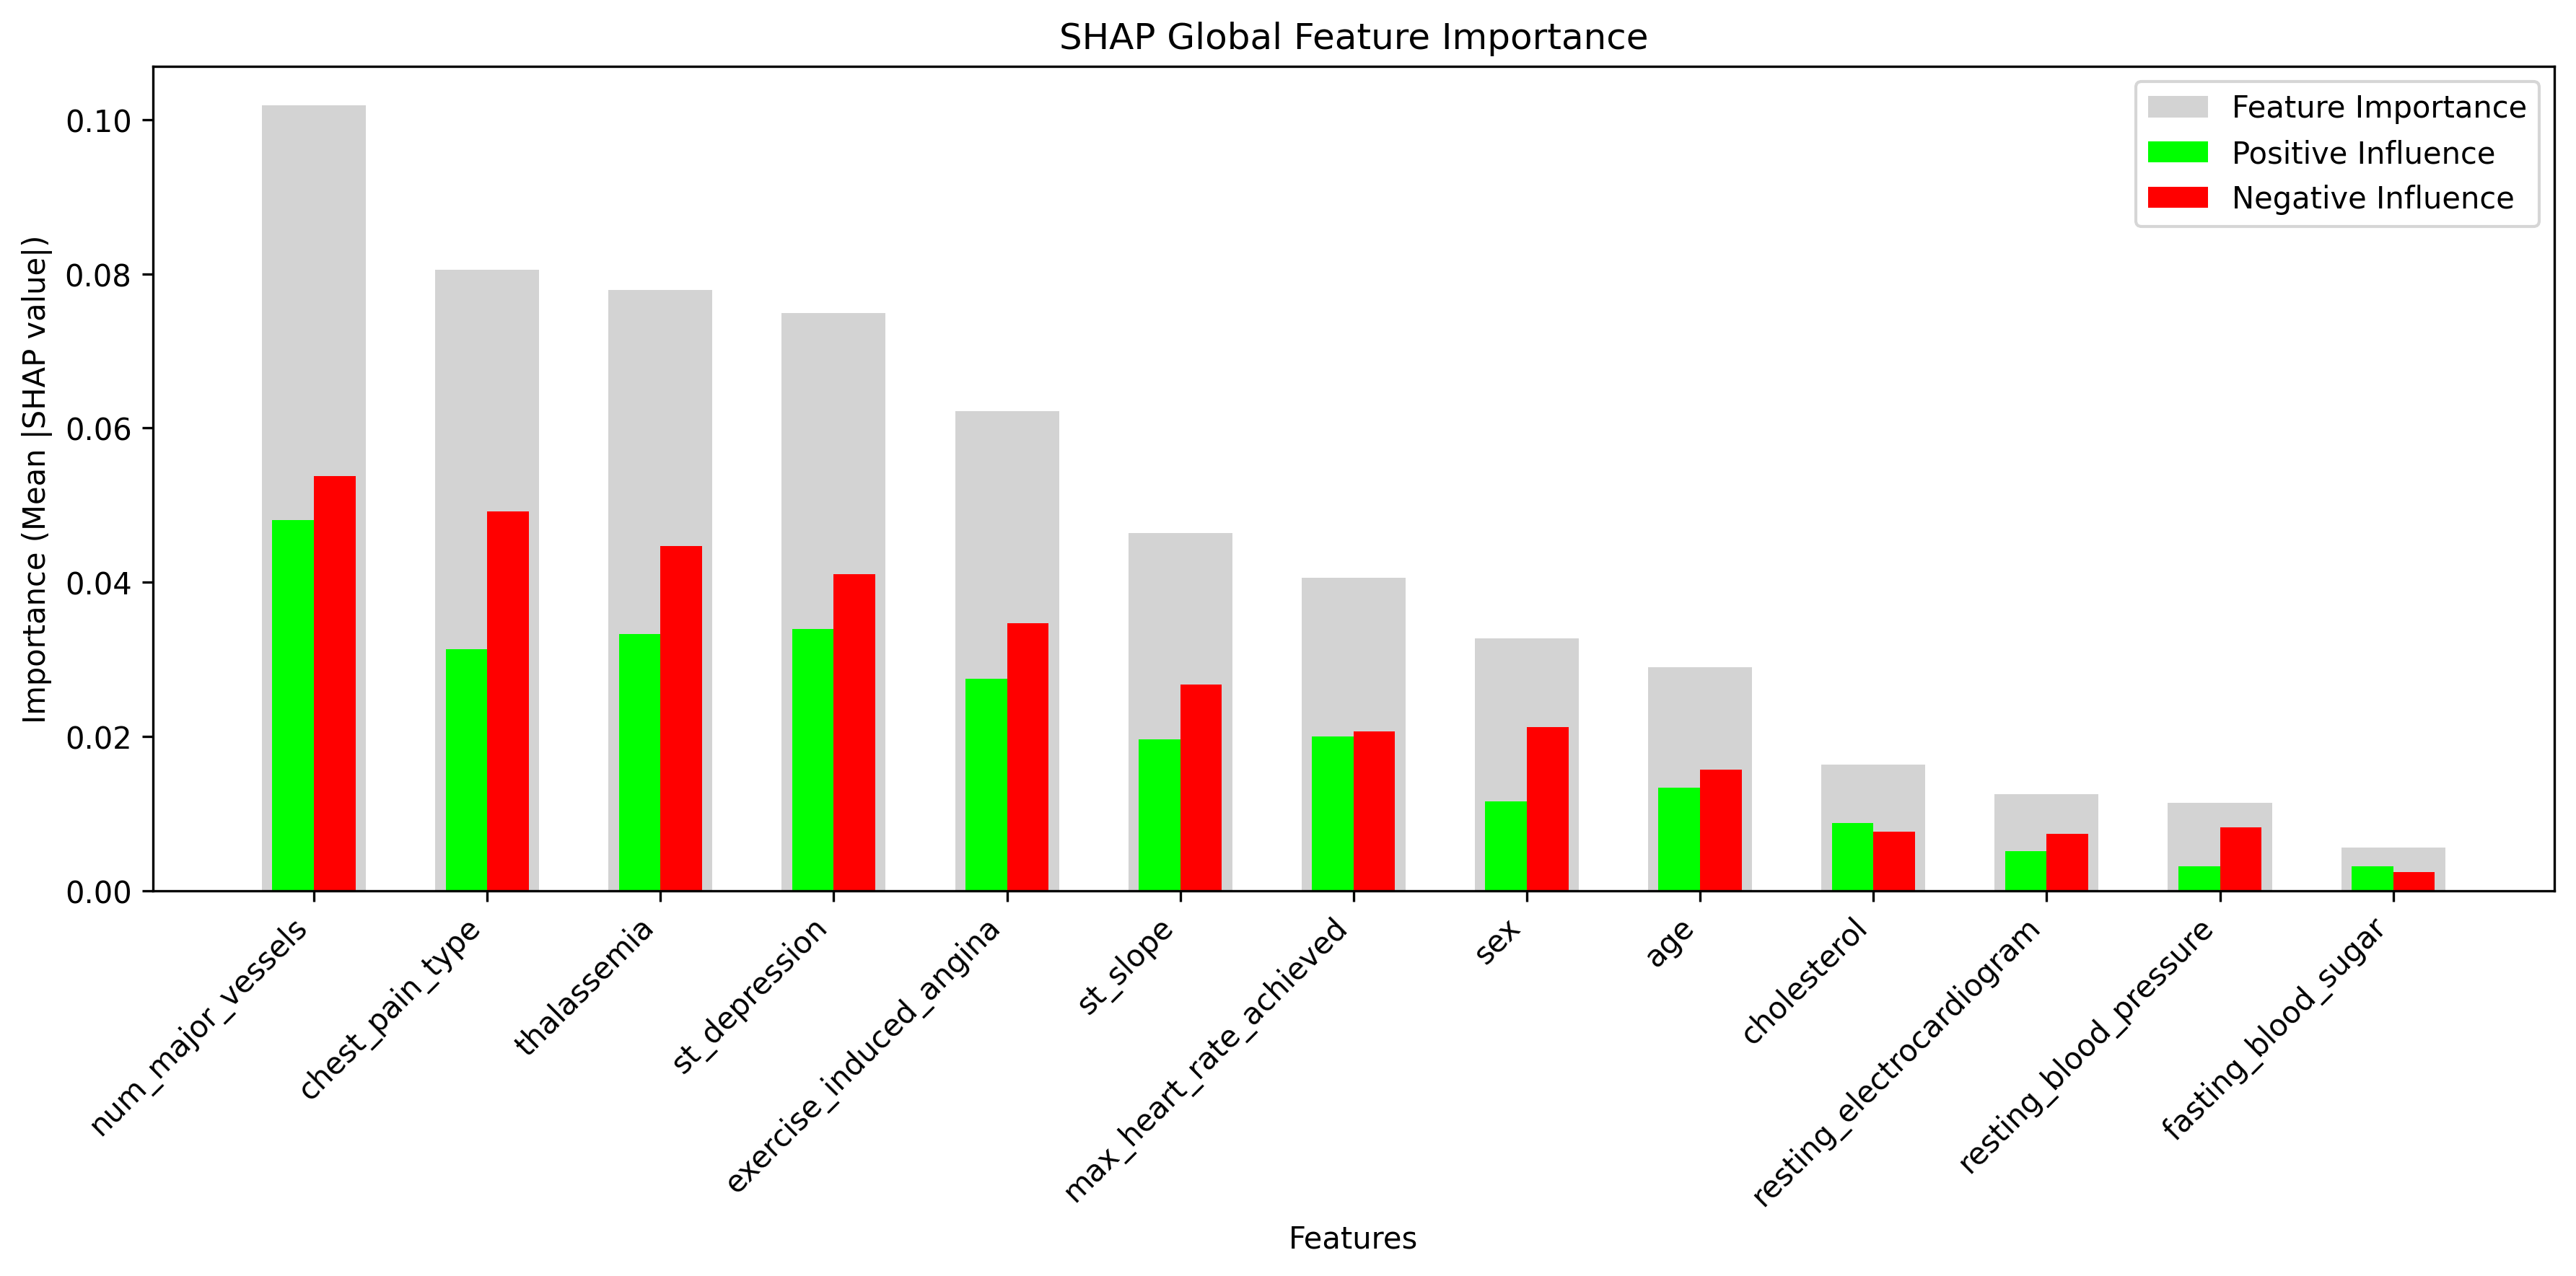

In [6]:
feature_importance = np.mean(np.abs(shap_values_class1), axis=0)
feature_names = X_test.columns

abs_shap = np.abs(shap_values_class1)
pos_mean = np.array([
    abs_shap[shap_values_class1[:, i] > 0, i].sum() / shap_values_class1.shape[0]
    for i in range(abs_shap.shape[1])
])
neg_mean = np.array([
    abs_shap[shap_values_class1[:, i] < 0, i].sum() / shap_values_class1.shape[0]
    for i in range(abs_shap.shape[1])
])

sorted_idx = np.argsort(feature_importance)[::-1]
sorted_features = feature_names[sorted_idx]
sorted_importance = feature_importance[sorted_idx]
pos_mean_sorted = pos_mean[sorted_idx]
neg_mean_sorted = neg_mean[sorted_idx]

plt.figure(figsize=(12, 6), dpi=300)
ax = plt.gca()

x = np.arange(len(sorted_features))
width = 0.6

ax.bar(x, sorted_importance, color='lightgray', width=width, zorder=1, label='Feature Importance')

bar_width = width * 0.4
ax.bar(x - bar_width/2, pos_mean_sorted, width=bar_width, color='lime', zorder=2, label='Positive Influence')
ax.bar(x + bar_width/2, neg_mean_sorted, width=bar_width, color='red', zorder=2, label='Negative Influence')

ax.set_xticks(x)
ax.set_xticklabels(sorted_features, rotation=45, ha='right')
ax.set_ylabel("Importance (Mean |SHAP value|)")
ax.set_xlabel("Features")
ax.set_title("SHAP Global Feature Importance")

ax.legend()
plt.tight_layout()
plt.show()
